In [1]:
import os
import json
from web3 import Web3, HTTPProvider


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import datetime

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [3]:
pool_addr = "0x8301AE4fc9c624d1D396cbDAa1ed877821D7C511"
lp_token_addr = "0xEd4064f376cB8d68F770FB1Ff088a3d0F3FF5c4d"
tricrypto_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"

In [4]:
admin_2 = "0xA464e6DCda8AC41e03616F95f4BC98a13b8922Dc"
admin = "0xeCb456EA5365865EbAb8a2661B0c503410e9B347"

In [5]:
pool_addr.lower()

'0x8301ae4fc9c624d1d396cbdaa1ed877821d7c511'

In [6]:
with open("./crveth.json", 'r') as f:
    abi = json.load(f)
crveth = web3.eth.contract(address=pool_addr, abi=abi)

with open("../tricrypto/tricrypto2.json", 'r') as f:
    abi = json.load(f)
tricrypto2 = web3.eth.contract(address=tricrypto_addr, abi=abi)

In [7]:
start_block = 13676983
current_block = web3.eth.get_block_number()

In [8]:
datetime.datetime.fromtimestamp(web3.eth.getBlock(13685675)['timestamp'])

datetime.datetime(2021, 11, 25, 21, 50, 4)

In [27]:
swaps = []

transfer_filter = crveth.events.TokenExchange.createFilter(
    fromBlock=start_block,
    toBlock=current_block
)
all_transfers = transfer_filter.get_all_entries()
claimed_lp_tokens = 0
for transfer in all_transfers:

    block = transfer['blockNumber']
    tx_hash = transfer['transactionHash'].hex()
    timestamp = datetime.datetime.fromtimestamp(web3.eth.getBlock(block)['timestamp'])

    eth_price = tricrypto2.functions.price_oracle(1).call(block_identifier=block) * 1e-18

    crv_to_eth_swap = transfer['args']['sold_id'] == 1
    eth_to_crv_swap = transfer['args']['sold_id'] == 0

    tokens_sold = transfer['args']['tokens_sold'] * 1e-18
    tokens_bought = transfer['args']['tokens_bought'] * 1e-18

    total_eth_sold = 0
    if eth_to_crv_swap:
        total_eth_sold = tokens_sold
    total_eth_bought = 0
    if crv_to_eth_swap:
        total_eth_bought = tokens_bought

    total_transaction_eth = total_eth_bought + total_eth_sold
    total_transaction_usd = total_transaction_eth * eth_price

    dict_fees = {
        'block': block,
        'timestamp': timestamp,
        'volume_usd': total_transaction_usd,
        'tx_hash': tx_hash
    }
    swaps.append(dict_fees)

df_swaps = pd.DataFrame(swaps)
df_swaps

,block,timestamp,volume_usd,tx_hash
0,13678341,2021-11-24 17:53:26,21197.554406,0xcae8539cb9af87f0fe13faa3edbfdc20bbc75b14f315...
1,13678459,2021-11-24 18:19:01,4237.497934,0x4b547246e710350a8acb9c46203740f09a3cecebf444...
2,13678478,2021-11-24 18:22:01,21183.528806,0x97aa73bb0b69064c7142b132a05bad43d5f971f2848a...
3,13678595,2021-11-24 18:48:04,17377.539701,0x89e1cfe36085c6a89a2149320310dae52964dd840324...
4,13678633,2021-11-24 18:54:57,1621.443716,0x87c638088c5ba95787e26e91ae2441f867c6e65ac2c4...
...,...,...,...,...
505,13754086,2021-12-06 20:18:38,40019.278266,0x2017b1bcfa5db9bb5013bd311e384586326b77f4d036...
506,13754088,2021-12-06 20:19:42,39844.676819,0x2da61bcb7629ab6ac9720795d1a3d4bd9531c4bf6923...
507,13754093,2021-12-06 20:20:47,39718.384772,0xc54ccd0b2d3e6e0977829a1448238529f37c030a57f7...
508,13754113,2021-12-06 20:26:27,8391.250522,0x551bfa8dcf24e2eee12e40cfd58391e4e9eb2006953a...


In [28]:
df_swaps.set_index('timestamp', inplace=True)

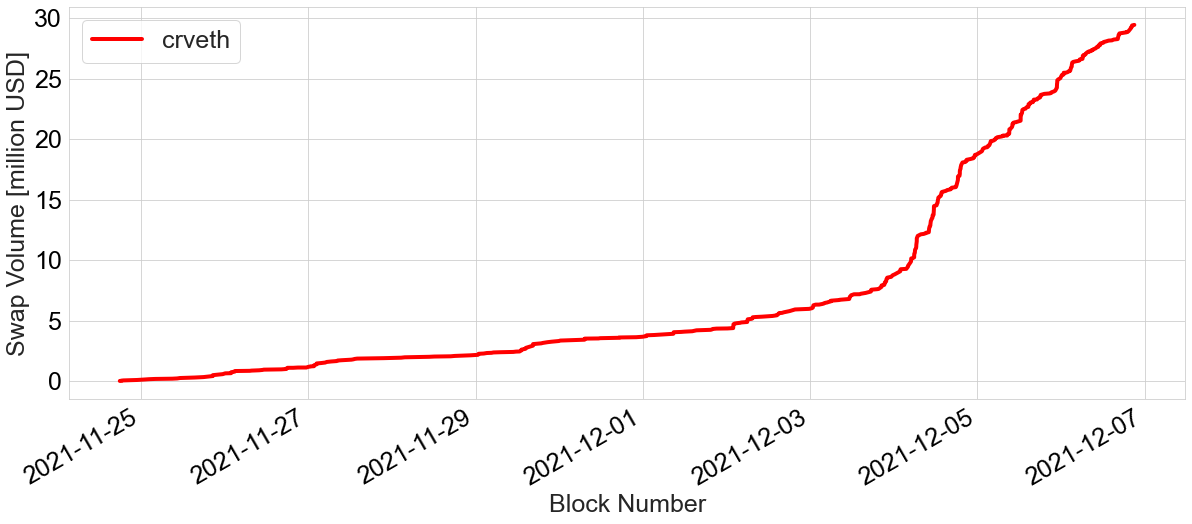

In [33]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_swaps['volume_usd'] * 1e-6).cumsum().plot(
    ax=ax,
    color='red',
    label='crveth',
    lw=4
)

ax.set_ylabel("Swap Volume [million USD]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);